In [18]:
# imports
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship, aliased
from sqlalchemy.ext.declarative import declarative_base
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
import glob
import re
%matplotlib inline

In [2]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'NANOOS_PRISMCRUISES/'
dbname='PRISM'

In [3]:
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite')

In [3]:
dirs=[x for x in os.listdir(basedir) if os.path.isdir(basedir+x)]
print(dirs)

['PRISM_Cruise-2008_August-Data', 'PRISM_Cruise-2008_February-Data', 'PRISM_Cruise-2011_October-Data', 'PRISM_Cruise-2000_June-Data', 'PRISM_Cruise-1998_December-Data', 'PRISM_Cruise-2009_September-Data', 'PRISM_Cruise-2010_October-Data', 'PRISM_Cruise-2004_December-Data', 'PRISM_Cruise-2001_November-Data', 'PRISM_Cruise-1999_June-Data', 'PRISM_Cruise-1998_June-Data', 'PRISM_Cruise-2001_June-Data', 'PRISM_Cruise-2006_December-Data', 'PRISM_Cruise-2000_December-Data', 'PRISM_Cruise-2005_June-Data', 'PRISM_Cruise-2002_June-Data', 'PRISM_Cruise-2002_December-Data', 'PRISM_Cruise-2003_June-Data', 'PRISM_Cruise-2004_July-Data', 'PRISM_Cruise-2009_December-Data', 'PRISM_Cruise-2003_December-Data', 'PRISM_Cruise-1999_August-Data', 'PRISM_Cruise-2007_June-Data', 'PRISM_Cruise-2006_June-Data', 'PRISM_Cruise-2009_February-Data', 'PRISM_Cruise-2005_December-Data', 'PRISM_Cruise-1999_December-Data']


In [5]:
Base=declarative_base()

In [6]:
class forceNumeric(types.TypeDecorator):

    impl = types.Numeric

    def process_bind_param(self, value, dialect):
        try:
            int(float(value))
        except:
            value = None
        return value

class forceInt(types.TypeDecorator):
    
    impl = types.Integer
    def process_bind_param(self, value, dialect):
        try:
            int(value)
        except:
            value = None
        return value


In [7]:
def coltype(ikey):
    typedict = {
        'cast_lat': forceNumeric(),
        'cast_lon': forceNumeric(),
        'cast_dbid': forceInt(),
        'depth': forceNumeric(),
        'value': forceNumeric(),
        'station_lat': forceNumeric(),
        'station_lon': forceNumeric(),
    }
    return typedict.get(ikey, String())
    

In [8]:
f0Obs=glob.glob(basedir+dirs[0]+'/*_ObservationsData_*.csv')[0]
print(f0Obs)
f0Info=glob.glob(basedir+dirs[0]+'/*_Information_*.csv')[0]
print(f0Info)
f0Cast=glob.glob(basedir+dirs[0]+'/*_CastInformation_*.csv')[0]
print(f0Cast)

/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_August-Data/PRISM_Cruise_Aug_2008_ObservationsData_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_August-Data/PRISM_Cruise_Aug_2008_Information_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_August-Data/PRISM_Cruise_Aug_2008_CastInformation_NANOOSver20120514.csv


In [9]:
f=open(f0Info,'r')
headerInfo=re.split('\s*,\s*',f.readline().rstrip())
print (headerInfo)
headerInfo = [x for x in headerInfo if x not in {'cruise_code'}]
print(headerInfo)
f.close()
f=open(f0Cast,'r')
headerCast=re.split('\s*,\s*',f.readline().rstrip())
print (headerCast)
headerCast = [x for x in headerCast if x not in {'cast_dbid'}]
print(headerCast)
f.close()
f=open(f0Obs,'r')
headerObs=re.split('\s*,\s*',f.readline().rstrip())
print (headerObs)
headerObs = [x for x in headerObs if x not in {'cast_dbid'}]
print(headerObs)
f.close()

['cruise_name', 'cruise_code', 'datetime_mid', 'datetime_start', 'datetime_end']
['cruise_name', 'datetime_mid', 'datetime_start', 'datetime_end']
['cast_dbid', 'cast_type', 'cast_datetime', 'cast_lat', 'cast_lon', 'station_name', 'station_lat', 'station_lon']
['cast_type', 'cast_datetime', 'cast_lat', 'cast_lon', 'station_name', 'station_lat', 'station_lon']
['cast_dbid', 'cast_type', 'cast_datetime', 'cast_lat', 'cast_lon', 'station_name', 'depth', 'analysis_method', 'variable', 'value']
['cast_type', 'cast_datetime', 'cast_lat', 'cast_lon', 'station_name', 'depth', 'analysis_method', 'variable', 'value']


In [10]:
class InfoTBL(Base):
    __table__ = Table('InfoTBL', Base.metadata, 
                Column('cruise_code', String, primary_key=True),
                *(Column(cname, coltype(cname)) for cname in headerInfo))

In [11]:
class CastTBL(Base):
    __table__=Table('CastTBL', Base.metadata,
                Column('cast_dbid', forceInt, primary_key=True),
                Column('cruise_code',String, ForeignKey('InfoTBL.cruise_code')),
                *(Column(cname, coltype(cname)) for cname in headerCast))
    
    info=relationship(InfoTBL, primaryjoin=__table__.c.cruise_code == InfoTBL.cruise_code)
    

In [12]:
class ObsTBL(Base):
    __table__=Table('ObsTBL', Base.metadata,
                    Column('id', Integer, primary_key=True),
                    Column('cast_dbid', forceInt, ForeignKey('CastTBL.cast_dbid')),
                    *(Column(cname, coltype(cname)) for cname in headerObs))
           
    cast=relationship(CastTBL, primaryjoin=__table__.c.cast_dbid == CastTBL.cast_dbid)

In [13]:
Base.metadata.create_all(engine)

In [14]:
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [15]:
for idir in dirs:
    fObs=glob.glob(basedir+idir+'/*_ObservationsData_*.csv')[0]
    print(fObs)
    fInfo=glob.glob(basedir+idir+'/*_Information_*.csv')[0]
    print(fInfo)
    fCast=glob.glob(basedir+idir+'/*_CastInformation_*.csv')[0]
    print(fCast)
    
    f=open(fInfo,'r')
    cf = csv.DictReader(f, delimiter=',')
    ri=0
    for row in cf:
        ri+=1
        session.execute(InfoTBL.__table__.insert().values(**row))
        if ri>1: 
            print('WARNING: Multiple rows in Info csv')
    cc=row['cruise_code']
    f.close()

    f=open(fCast,'r')
    cf = csv.DictReader(f, delimiter=',')
    for row in cf:
        session.execute(CastTBL.__table__.insert().values(cruise_code=cc,**row))
    f.close()

    f=open(fObs,'r')
    cf = csv.DictReader(f, delimiter=',')
    for row in cf:
        session.execute(ObsTBL.__table__.insert().values(**row))
    f.close()
    

/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_August-Data/PRISM_Cruise_Aug_2008_ObservationsData_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_August-Data/PRISM_Cruise_Aug_2008_Information_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_August-Data/PRISM_Cruise_Aug_2008_CastInformation_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_February-Data/PRISM_Cruise_Feb_2008_ObservationsData_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_February-Data/PRISM_Cruise_Feb_2008_Information_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2008_February-Data/PRISM_Cruise_Feb_2008_CastInformation_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cruise-2011_October-Data/PRISM_Cruise_Oct_2011_ObservationsData_NANOOSver20120514.csv
/ocean/eolson/MEOPAR/obs/NANOOS_PRISMCRUISES/PRISM_Cr

In [16]:
session.commit()

In [4]:
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
InfoTBL=Base.classes.InfoTBL
CastTBL=Base.classes.CastTBL
ObsTBL=Base.classes.ObsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [7]:
vartypes=session.query(ObsTBL.variable).group_by(ObsTBL.variable).all()
print(vartypes)

[('ammonium_concentration',), ('chl_concentration',), ('light_transmissivity',), ('nitrate_concentration',), ('nitrite_concentration',), ('oxygen_concentration',), ('phaeophytin_concentration',), ('phosphate_concentration',), ('photosynthetically_active_radiation',), ('potential_density_sigmat',), ('silicate_concentration',), ('turbidity',), ('water_pressure',), ('water_salinity',), ('water_temperature',)]


In [79]:
qNLoc=session.query(ObsTBL.cast_dbid, ObsTBL.cast_datetime, ObsTBL.cast_lat, ObsTBL.cast_lon, ObsTBL.cast_datetime, ObsTBL.depth,
    ObsTBL.value).filter(
    and_(
        ObsTBL.variable == 'nitrite_concentration',
        ObsTBL.cast_lat > 48.3,
        ObsTBL.cast_lat < 48.8,
        ObsTBL.cast_lon > -125.2,
        ObsTBL.cast_lon < -124.3,
        )).subquery()

In [80]:
test=session.query(qNLoc.c.value).count()
print(test)

164


In [81]:
qT=session.query(ObsTBL.cast_dbid, ObsTBL.depth, ObsTBL.value).filter(ObsTBL.variable == 'water_temperature').subquery()

In [82]:
AqNLoc=aliased(qNLoc)
AqT=aliased(qT)

In [83]:
qNLocT=session.query(AqNLoc.c.cast_dbid, AqNLoc.c.cast_datetime, AqNLoc.c.cast_lat, AqNLoc.c.cast_lon, AqNLoc.c.depth, AqNLoc.c.value.label('N'), 
        AqT.c.value.label('T')).filter(AqNLoc.c.cast_dbid==AqT.c.cast_dbid, AqNLoc.c.depth==AqT.c.depth).subquery()

In [84]:
qS=session.query(Salias.cast_dbid, Salias.depth, Salias.value).filter(Salias.variable == 'water_salinity').subquery()
AqS=aliased(qS)

In [85]:
qNLocTS=session.query(qNLocT.c.cast_dbid, qNLocT.c.cast_datetime, qNLocT.c.cast_lat, qNLocT.c.cast_lon, qNLocT.c.depth, qNLocT.c.N, 
        qNLocT.c.T, AqS.c.value.label('S')).filter(qNLocT.c.cast_dbid==AqS.c.cast_dbid, qNLocT.c.depth==AqS.c.depth).subquery()

In [87]:
for date, depth in session.query(qNLocTS.c.cast_datetime, qNLocTS.c.depth).filter(qNLocTS.c.S==0).all():
    print(date,depth)

2004-07-17 13:34:06.000003 2.3970000000
2004-07-17 13:34:06.000003 7.4570000000
2004-07-17 13:34:06.000003 12.3980000000
2004-07-17 13:34:06.000003 22.2380000000
2004-07-17 13:34:06.000003 31.8170000000
2004-07-17 13:34:06.000003 51.8670000000
2004-07-17 13:34:06.000003 76.8110000000
2004-07-17 13:34:06.000003 101.6000000000
2004-07-17 13:34:06.000003 151.0900000000
2004-07-17 13:34:06.000003 222.6800000000
2004-07-17 15:11:39.000001 2.5280000000
2004-07-17 15:11:39.000001 7.6670000000
2004-07-17 15:11:39.000001 12.8310000000
2004-07-17 15:11:39.000001 22.3230000000
2004-07-17 15:11:39.000001 31.6630000000
2004-07-17 15:11:39.000001 50.3450000000
2004-07-17 15:11:39.000001 76.7950000000
2004-07-17 15:11:39.000001 101.5900000000
2004-07-17 15:11:39.000001 146.4100000000
2004-07-17 15:11:39.000001 198.2600000000
2004-07-17 15:11:39.000001 251.7600000000
2004-07-17 16:16:11.999995 3.1480000000
2004-07-17 16:16:11.999995 8.3820000000
2004-07-17 16:16:11.999995 12.7510000000
2004-07-17 16:1

In [75]:
data=session.query(qNLocTS).filter(qNLocTS.c.depth>75, qNLocTS.c.S>0).all()
NO=[]
S=[]
T=[]
for dbid, lat, lon, depth, N, Tem, Sal in data:
    S.append(Sal)
    NO.append(N)
    T.append(Tem)


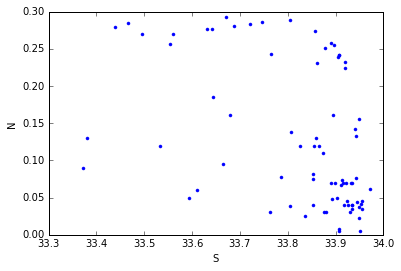

In [76]:
plt.plot(S,NO,'.')
plt.xlabel('S')
plt.ylabel('N')

In [88]:
session.close()
engine.dispose()